In [2]:
import math

import numpy as np
import qiskit.quantum_info
from sympy import *
import random
from qiskit import *
from qiskit import IBMQ
import pylatexenc
import scipy as sp
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy import linalg as sla
from IPython.display import clear_output
from numpy import linalg as la
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit import Parameter
from qiskit.compiler import transpile, assemble
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.visualization import *
from operator import itemgetter
from functools import reduce

In [3]:
file = open("key.txt", "r")
key = file.read()
IBMQ.save_account(key)
IBMQ.load_account()
provider = IBMQ.get_provider()

print(provider.backends())

# backend = provider.get_backend('ibmq_belem')
backend = provider.get_backend('ibmq_qasm_simulator')
# backend = provider.get_backend('simulator_statevector')
# simulator = Aer.get_backend('aer_simulator')
print(backend)

configrc.store_credentials:WARNING:2021-10-21 15:50:40,403: Credentials already present. Set overwrite=True to overwrite.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') fro

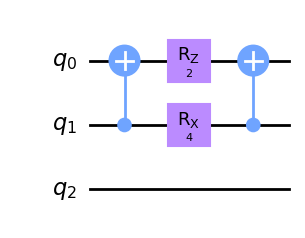

In [4]:
#turn on hadamards to get all 4 states present
def make_cont_sys_circ(inTime, xMod, zMod):
    temp = QuantumCircuit(3)

    # temp.h(0)

    temp.cx(1, 0)

    temp.rx(2 * xMod * inTime, 1)
    temp.rz(2 * zMod * inTime, 0)

    temp.cx(1, 0)

    # temp.h(0)

    return temp

temp = QuantumCircuit(3)

temp.compose(make_cont_sys_circ(1, 2, 1), [0, 1, 2], inplace=True)

temp.draw('mpl')

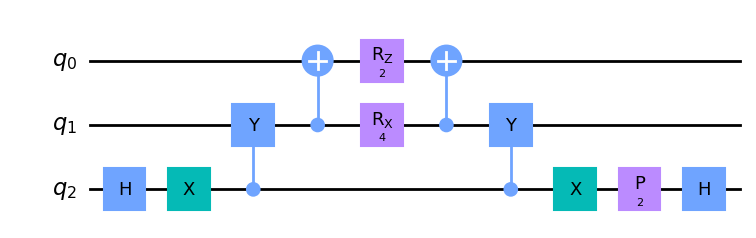

In [5]:
def make_cycle(time, ETarget, xMod, zMod):
    cycle = QuantumCircuit(3)

    cycle.h(2)

    cycle.x(2)
    cycle.cy(2, 1)

    cycle.compose(make_cont_sys_circ(time, xMod, zMod), [0, 1, 2], inplace=True)

    cycle.cy(2, 1)
    cycle.x(2)

    cycle.p(time * ETarget * 2, 2)

    cycle.h(2)

    return cycle

test = QuantumCircuit(3)
test.compose(make_cycle(1, 1, 2, 1), [0, 1, 2], inplace=True)
test.draw('mpl')

In [6]:
#TODO: Find way to gaurantee low overlap

t1 = np.random.normal(0, 5)
t2 = np.random.normal(0, 5)
t3 = np.random.normal(0, 5)
t4 = np.random.normal(0, 5)
t5 = np.random.normal(0, 5)

print(t1)
print(t2)
print(t3)
print(t4)
print(t5)

0.31489344845470196
0.45767718714380956
1.213841976576334
2.893200684650126
-3.885531518973642


-3.0: 
84
{'00000': 84, '00001': 92, '00010': 98, '00011': 331, '00100': 78, '00101': 77, '00110': 106, '00111': 158}
-1.0: 
532
{'00000': 532, '00001': 8, '00010': 42, '00011': 29, '00100': 3, '00101': 408, '00110': 1, '00111': 1}
1.0: 
134
{'00000': 134, '00001': 131, '00010': 174, '00011': 48, '00100': 113, '00101': 117, '00110': 247, '00111': 60}
3.0: 
514
{'00000': 514, '00001': 9, '00010': 44, '00011': 33, '00100': 4, '00101': 417, '00110': 1, '00111': 2}


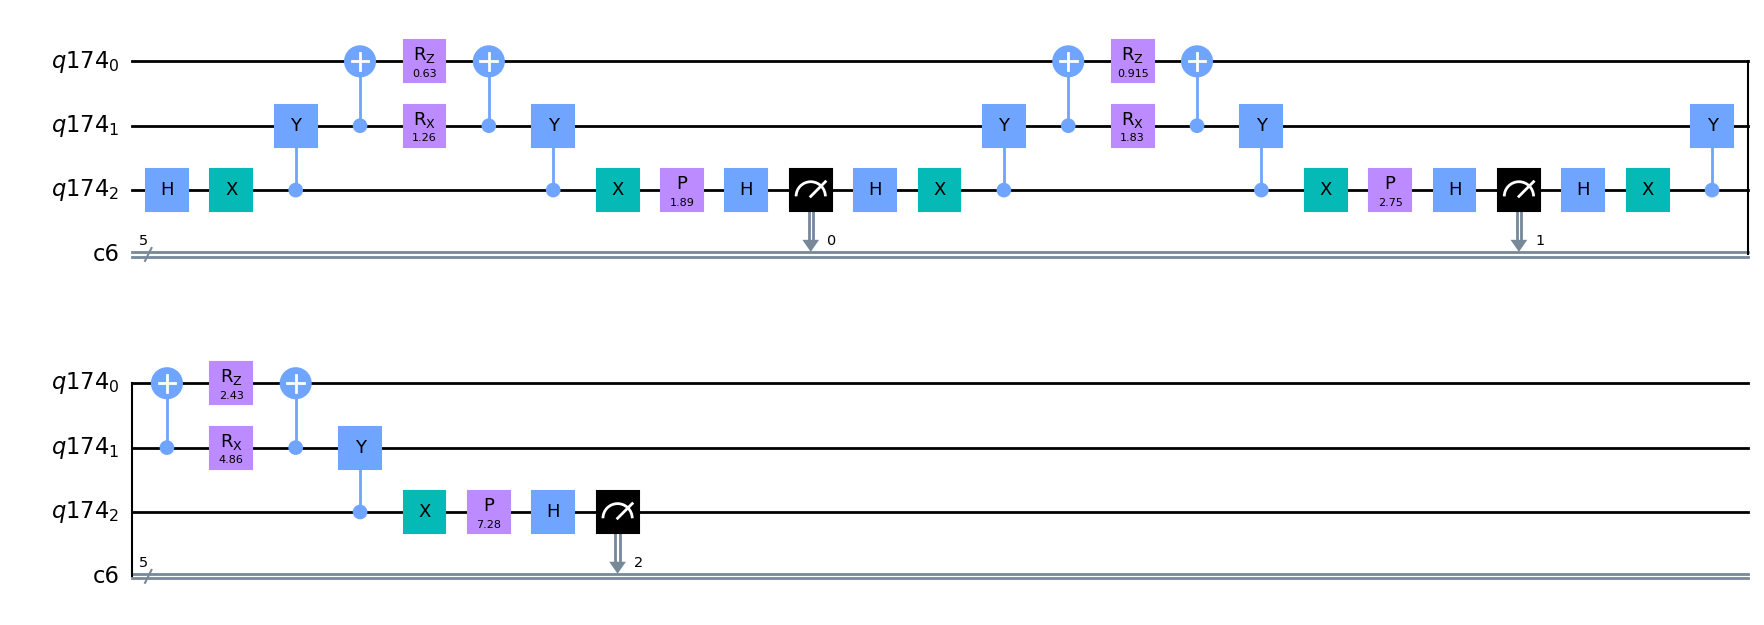

In [8]:
# Unused test code

specSuccess4 = list()
specAll4 = list()

vectors = [[0, 0, -1/sqrt(2), 0, 1/sqrt(2), 0, 0, 0], [1/sqrt(2), 0, 0, 0, 0, 0, 1/sqrt(2), 0], [-1/sqrt(2), 0, 0, 0, 0, 0, 1/sqrt(2), 0], [0, 0, 1/sqrt(2), 0, 1/sqrt(2), 0, 0, 0]]
#eigenstate (tensor) {1,0}
values = [-3, 3, -1, 1]

#initial_state = [1/sqrt(2), 0, 0, -1/sqrt(2), 0, 0, 0,0]
#initial_vector = qiskit.quantum_info.Statevector(initial_state)

for i in Range(4):
    energies = [-3, -1, 1, 3]
    eTarget = energies[i]
    # eTarget = -3 + (i) * 2
    # eTarget = i/10 - 5

    eTarget = float(eTarget)
    print(str(eTarget) + ": ")

    rodeo = QuantumCircuit(QuantumRegister(3), ClassicalRegister(5))

    # rodeo.initialize(initial_vector)
    # rodeo.h(2)
    # rodeo.x(1)
    # rodeo.x(2)
    # rodeo.p(1, 0)

    rodeo.compose(make_cycle(t1, eTarget, 2, 1), [0, 1, 2], inplace=True)
    rodeo.measure(2, 0) #cbit 0000n

    rodeo.compose(make_cycle(t2, eTarget, 2, 1), [0, 1, 2], inplace=True)
    rodeo.measure(2, 1) #cbit 000n0

    rodeo.compose(make_cycle(t3, eTarget, 2, 1), [0, 1, 2], inplace=True)
    rodeo.measure(2, 2) #cbit 00n00
    #
    # rodeo.compose(make_cycle(t4, eTarget), [0, 1, 2], inplace=True)
    # rodeo.measure(0, 3) #cbit 0n000
    #
    # rodeo.compose(make_cycle(t5, eTarget), [0, 1, 2], inplace=True)
    # rodeo.measure(0, 4) #cbit n0000


    job = execute(rodeo, backend=backend)
    job.wait_for_final_state()

    numSuccess = job.result().get_counts().get('00000')
    if numSuccess is None:
        numSuccess = 0

    print(numSuccess)
    specSuccess4.append(numSuccess)

    print(job.result().get_counts())

rodeo.draw('mpl')

In [5]:
def run_rodeo(times, numCycles, ETarget, xMod, zMod, twoStateTime = None):
    # debug printing
    # if twoStateTime is None:
    #     print('running energy = ' + str(ETarget))
    # else:
    #     print('running energy = ' + str(ETarget) + '; second time evolve is: ' + str(twoStateTime))

    rodeo = QuantumCircuit(QuantumRegister(3), ClassicalRegister(numCycles + 1))

    for i in range(numCycles):
        rodeo.compose(make_cycle(times[i], ETarget, xMod, zMod), [0, 1, 2], inplace=True)
        rodeo.measure(2, i + 1)

    if twoStateTime is not None:
        rodeo.compose(make_cont_sys_circ(twoStateTime, xMod, zMod), [0, 1, 2], inplace=True)
        rodeo.measure(1, 0)

    return rodeo

# old code from before job manager
# job = execute(rodeo, backend=backend)
# job.wait_for_final_state()
# state = '0'
# for i in range(numCycles):
#     state = state + '0'
#
# return job.result().get_counts().get(state)

times = list()
for i in range (3):
    times.append(np.random.normal(0, 5))
job = execute(run_rodeo(times, 3, -1, 2.5, 1.5), backend=backend)
job.wait_for_final_state()
state = '0'
for i in range(3):
    state = state + '0'

print(job.result().get_counts().get(state))

567


In [61]:
times = list()
for i in range (3):
    times.append(np.random.normal(0, 5))
state = '0'
for i in range(3):
    state = state + '0'

jobManager = IBMQJobManager()
circs = list()

for i in [-4, -1, 1, 4]:
    circs.append(run_rodeo(times, 3, i, 2.5, 1.5))
circs = transpile(circs, backend=backend)
job = jobManager.run(circs, backend=backend, name = "test eigenvalues")
results = job.results()
for i in range(4):
    print(results.get_counts(i).get(state))

running energy = -4
running energy = -1
running energy = 1
running energy = 4
297
216
245
268


In [17]:
#TODO: make threshold rigorous
#TODO: scan multiple times (25 times at 1024 shots)

def search_spectrum(linspace, threshold, numCycles, laterScanNum, numSecond, xMod, zMod):
    delta = abs(linspace[1]) - abs(linspace[0])
    length = linspace[0] - linspace[-1]

    state = '0'
    for i in range(numCycles):
        state = state + '0'
    jobManager = IBMQJobManager()

    peaks = list()
    firstRunCircs = list()
    for i in linspace:
        times = []
        for j in range(numCycles):
            times.append(np.random.normal(0, 2))
        firstRunCircs.append(run_rodeo(times, numCycles, i, xMod, zMod))
    print("first pass w/ energies")
    print(linspace)
    firstRunCircs = transpile(firstRunCircs, backend=backend)
    firstRunJob = jobManager.run(firstRunCircs, backend=backend, name = "first_pass")
    firstRunResults = firstRunJob.results()

    for runNum in range(linspace.size):
        if firstRunResults.get_counts(runNum).get(state) is not None and firstRunResults.get_counts(runNum).get(state) >= threshold:
            peaks.append(linspace[runNum])
    print("second pass w/ peaks:")
    print(peaks)

    secondRunCircs = list()
    energyList = list()
    for i in peaks:
        for j in np.linspace(i - delta/2, i + delta/2, laterScanNum):
            for num in range(numSecond):
                times = []
                for k in range(numCycles):
                    times.append(np.random.normal(0, 7))
                # print('energy: ' + str(j))
                secondRunCircs.append(run_rodeo(times, numCycles, j, xMod, zMod))
                energyList.append(j)

    secondRunCircs = transpile(secondRunCircs, backend=backend)
    secondRunJob = jobManager.run(secondRunCircs, backend=backend, name = "second_run")
    secondRunResults = secondRunJob.results()
    print("done w/ second pass")

    return [secondRunResults, energyList, state, laterScanNum, numSecond]

In [52]:
#this code is genuinely terrible, but it works
def process_data(output):
    pairArray = []
    for i in range(int(len(output[1]) / (output[4]))):
        totalSuccess = 0
        for j in range(output[4]):
            if output[0].get_counts(i * output[4] + j).get(output[2]) is not None:
                totalSuccess = totalSuccess + output[0].get_counts(i * output[4] + j).get(output[2])
        pairArray.append([output[1][i * output[4]], totalSuccess / output[4]])

    subScans = []
    for i in range(int(len(pairArray) / output[3])):
        temp = []
        for k in range(output[3]):
            temp.append(pairArray[k + i * output[3]])
        temp.reverse()
        subScans.append(temp)
    return subScans

In [26]:
def plot_scans(data):
    energy = []
    successes = []
    for i in data:
        for j in i:
            energy.append(j[0])
            if j[1] is not None:
                successes.append(j[1])

    hist1 = plt.bar(energy, successes, width=(0.8*(energy[1]-energy[0])))
    plt.show()

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-5.0, -3.0, -2.0, -1.0, 0.0, 3.0, 4.0]
done w/ second pass
3675
[[[-5.5, 143.2], [-5.45, 154.56], [-5.4, 84.72], [-5.35, 100.76], [-5.3, 127.4], [-5.25, 121.36], [-5.2, 136.0], [-5.15, 85.0], [-5.1, 102.92], [-5.05, 135.52], [-5.0, 122.88], [-4.95, 160.64], [-4.9, 95.92], [-4.85, 136.56], [-4.8, 150.64], [-4.75, 150.88], [-4.7, 159.36], [-4.65, 135.72], [-4.6, 110.92], [-4.55, 143.32], [-4.5, 136.76]], [[-3.5, 110.16], [-3.45, 119.88], [-3.4, 108.72], [-3.35, 115.32], [-3.3, 122.76], [-3.25, 164.96], [-3.2, 168.28], [-3.15, 166.52], [-3.1, 114.0], [-3.05, 120.0], [-3.0, 125.08], [-2.95, 159.68], [-2.9, 142.44], [-2.85, 128.88], [-2.8, 140.8], [-2.75, 139.24], [-2.7, 117.36], [-2.65, 92.52], [-2.6, 152.0], [-2.55, 110.84], [-2.5, 120.92]], [[-2.5, 137.32], [-2.45, 107.56], [-2.4, 142.64], [-2.35, 72.96], [-2.3, 82.92], [-2.25, 137.52], [-2.2, 150.32], [-2.15, 127.12], [-2.1, 152.64], [-2.05, 126.

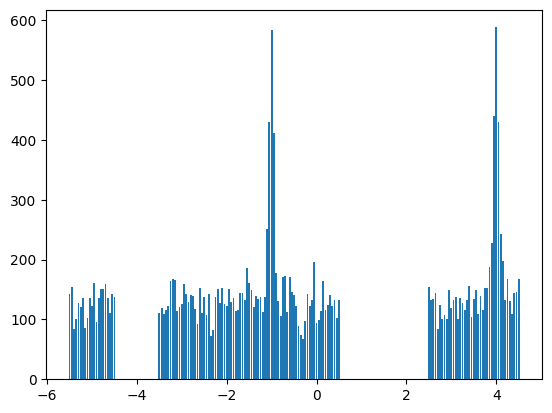

In [56]:
threeCycleOut = search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, 2.5, 1.5)
# print(threeCycleOut)
print(len(threeCycleOut[1]))
threeCycle2 = process_data(threeCycleOut)
print(threeCycle2)

plot_scans(threeCycle2)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-3.0, -2.0, 2.0, 4.0]
done w/ second pass
[[[-3.5, 128.68], [-3.4, 135.64], [-3.3, 139.24], [-3.2, 125.92], [-3.1, 199.44], [-3.0, 132.6], [-2.9, 102.56], [-2.8, 119.32], [-2.7, 104.08], [-2.6, 139.84], [-2.5, 93.64]], [[-2.5, 89.8], [-2.4, 117.4], [-2.3, 132.0], [-2.2, 138.92], [-2.1, 162.28], [-2.0, 226.72], [-1.9, 128.52], [-1.8, 98.84], [-1.7, 127.28], [-1.6, 103.52], [-1.5, 101.36]], [[1.5, 120.4], [1.6, 113.36], [1.7, 256.56], [1.7999999999999998, 533.12], [1.9, 167.36], [2.0, 144.32], [2.1, 85.68], [2.2, 151.56], [2.3, 132.2], [2.4, 190.48], [2.5, 100.76]], [[3.5, 142.04], [3.6, 145.12], [3.7, 314.16], [3.8, 558.56], [3.9, 155.6], [4.0, 150.28], [4.1, 118.16], [4.2, 95.2], [4.3, 143.44], [4.4, 128.64], [4.5, 119.04]]]


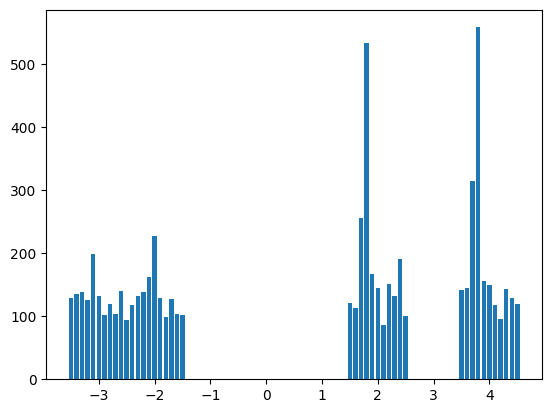

In [59]:
xmod1 = 1#.3359430644
zmod1 = 2.7803609513

randomTest = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 3, 11, 25, xmod1, zmod1))
print(randomTest)
plot_scans(randomTest)